In [1]:
import sys
sys.path.insert(0, "..")

%load_ext autoreload
%autoreload 2

In [38]:
from jax.config import config

config.update("jax_debug_nans", True)
from jaxgp.config import Config

import jaxgp as jgp
import jax.numpy as jnp
import jax.random as jr
from jaxgp.sgpr import SGPR
from scipy.optimize import minimize
import jaxopt
import numpy as np
import matplotlib.pyplot as plt

In [67]:
N = 500
noise = 1.
rng = np.random.RandomState(42)
X = rng.uniform(-3.0, 3.0, size=(N,))
f = lambda x: np.sin(4 * x) + np.cos(2 * x)
signal = f(X)
y = signal + rng.normal(size=signal.shape) * noise
Z = np.linspace(-5., 5., 10)
Xtest = np.linspace(-5.,  5., 500).reshape(-1, 1)
ytest = f(Xtest)

In [68]:
train_data = jgp.Dataset(X=X, Y=y)
kernel = jgp.RBF(active_dims=[0, 1])
model = SGPR(
    train_data=train_data,
    gprior=jgp.GPrior(kernel=kernel),
    likelihood=jgp.Gaussian(num_datapoints=train_data.N),
    inducing_points=Z,
)

params, constrain_trans, unconstrain_trans = jgp.initialise(model)
raw_params = unconstrain_trans(params)
neg_elbo = model.build_elbo(sign=-1.0)
print("Initial negative elbo = ", neg_elbo(raw_params))
solver = jaxopt.ScipyMinimize(
    fun=neg_elbo, jit=True, options={"disp": True}
)
soln = solver.run(raw_params)
print("After optimization negative elbo = ", soln.state.fun_val)
# Remember to transform since the optimization is in unconstrained space
final_params = constrain_trans(soln.params)
posterior = model.posterior()

Initial negative elbo =  826.3514113036671
         Current function value: 746.196074
         Iterations: 27
         Function evaluations: 124
         Gradient evaluations: 112
After optimization negative elbo =  746.1960737987777


In [69]:
pred_mean, pred_var = posterior.predict_f(
    Xtest, final_params, full_cov=False
)

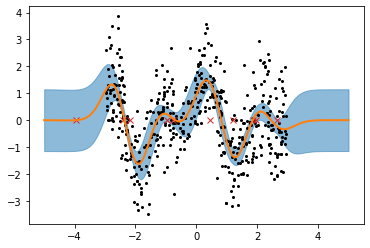

In [70]:
plt.plot(X, y, "o", color="k", markersize=2)
plt.plot(final_params["inducing_points"], np.zeros_like(Z), "x", color="tab:red")
plt.plot(Xtest, pred_mean, color="tab:orange", linewidth=2)
plt.fill_between(
    Xtest.squeeze(),
    pred_mean.squeeze() - 2*np.sqrt(pred_var.squeeze()),
    pred_mean.squeeze() + 2*np.sqrt(pred_var.squeeze()),
    alpha=0.5,
    color="tab:blue",
)

In [71]:
final_params

{'inducing_points': DeviceArray([[-3.95504648],
              [-2.40265795],
              [-0.77242675],
              [-0.96812799],
              [-2.19030179],
              [ 2.64790239],
              [ 1.8734758 ],
              [ 0.44249766],
              [ 1.21028365],
              [ 1.96407802]], dtype=float64),
 'kernel': {'lengthscale': DeviceArray([0.63763736, 0.63730692], dtype=float64),
  'outputscale': DeviceArray([0.32934049], dtype=float64)},
 'likelihood': {'noise': DeviceArray(1.09543567, dtype=float64)},
 'mean_function': {}}